&nbsp;

# 11 - Analyse des extrêmes

---

&nbsp;

L'analyse des extrêmes est une étape diagnostic du système, c'est-à-dire qu'elle va compléter le raisonnement concernant ce que doit apprendre le modèle, comment il doit l'apprendre et avec quelles hypothèses. 

L'objectif est d'objectiver les évènements "rares". Cela passe l'étude de leur durée, leur persistance, leur répartition temporelle et spatiale, leur saisonnalité et l'éventuelle présence de non-linéarité.

Suite au notebook 06, on a observé un kurtosis de Fisher légèrement supérieur au standard gaussien (~0.83 > 0). La positivité de cet indicateur prouve assez fiablement que les extrêmes ne sont pas anecdotiques. C'est un argument légitime pour imposer une analyse des extrêmes.

&nbsp;

> #### Que désignons-nous comme les extrêmes ?

Les extrêmes sont des événements de queue, difficiles à prédire par des modèles calibrés sur la moyenne. Ils correspondent à la partie de la distribution la plus mal contrainte par les approches statistiques classiques. 

On la mènera sur les anomalies de SST détrendées afin d’assurer la stationnarité des statistiques et de se concentrer sur les mécanismes dynamiques pertinents pour la modélisation SciML. 

&nbsp;

Le rôle spécifique avant SciML (et plus généralement avant n'importe quel ML) de l'analyse est en fait de répondre à la question suivante :

> #### Qu'est-ce qui est difficile à prédire ?

La réponse simple est "les évènements exceptionnels". La plupart des modèles de ML vont assez facilement prédire les valeurs moyennes. En revanche, la précision va grandement s'atténuer concernant la survenue, la durée ou l'intensité des évènements rares.

C'est assez normal en fait. Car ils sont peu représentés dans les données, un modèle linéaire va donc peiner à prédire des évènements non-linéaires car ils ont souvent un équivalent-mémoire.

&nbsp;

---

&nbsp;

## 1. Choix méthodologiques pour les extrêmes

&nbsp;

Statistiquement, on dira qu'un évènement extrême est défini comme un dépassement d'un quantile élevé de la distribution.

Deux approches sont possibles. La première *quantile-based* définit un extrême comme suit : 

$$ X(t) > q_p $$

où $q_p$ est le quantile $p$ de la série analysée.

Les avantages sont multiples, cela garantie un nombre suffisant d'évènements pour l'analyse statistique et une certaine robustesse au biais de moyenne. On pourra, en revanche, moins interprété physiquement les implications.

Au contraire, la méthode par *seuil absolu* permet une interprétation physique directe car elle définit un extrême à partir d'un seuil fixé de l'unité physique de la variable :

$$ X(t) > S $$

où S peut être un seuil de SST absolue (comme 20°).

Cette méthode de définition présente quelques inconvénients. Elle est sensible aux biais et à la tendance, demande de justifier scientifiquement le choix du seuil et dépend fortement de la saison.

&nbsp;

> #### Quelle méthode choisir ?

Dans ce travail, on préfera définir les évènements extrêmes à partir d'une approche *quantile-based*.

Premièrement, car nous travaillons avec les anomalies de SST détrendées, et cette méthode est adaptée à la nature du jeu de donnée. Sous peine de devoir, en plus de trouver un seuil absolu justifiable, mettre en forme ce seuil pour qu'il corresponde aux anomalies et soit adapté au caractère désaisonnalisé.

Deuxièmement, nous avons la volonté de nous concentrer sur la variabilité dynamique et la nécessité d'assurer la stationnarité statistique. L'approche par les quantiles permet de remplir ces deux critères.

On retiendra 2 seuils standards : 
- Quantile à 5% - 95% : pour caractériser les évènements "fréquents"
- Quantile à 1% - 99% : pour analyser les évènements rares et intenses

&nbsp;

---

&nbsp;

## 2. Quantiles extrêmes

### 2.1 Distribution des anomalies avec seuil des extrêmes

Analysons basiquement la distribution en mettant en évidence les 2 seuils standards énoncés précédemment. Commençons par une analyse régionale, c'est-à-dire que nous allons moyenner spatialement avant d'analyser quelconque extrêmes locales (en pixel par pixel).

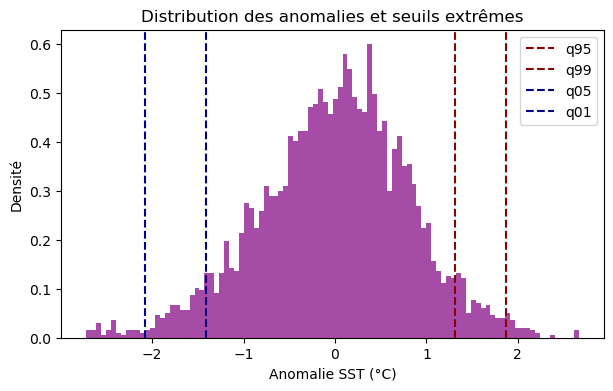

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Basic loading of processed SST data
ds = xr.open_dataset("data/processed/sstDeseasonalizedCOPERNICUS20102019.nc")
sst = ds["analysed_sst"]

# We generalize the computation of extreme thresholds over the entire region
sstReg = sst.mean(dim=("latitude", "longitude"))

# Computation of extreme quantiles
q95Reg = sstReg.quantile(0.95, dim="time")
q99Reg = sstReg.quantile(0.99, dim="time")

q1Reg = sstReg.quantile(0.01, dim="time")
q5Reg = sstReg.quantile(0.05, dim="time")

# Plotting the distribution of SST anomalies with extreme thresholds
plt.figure(figsize=(7, 4))
plt.hist(sstReg.values, bins=100, density=True, color="purple", alpha=0.7)
plt.axvline(q95Reg, linestyle="--", label="q95", color="darkred")
plt.axvline(q99Reg, linestyle="--", label="q99", color="darkred")
plt.axvline(q5Reg, linestyle="--", label="q05", color="darkblue")
plt.axvline(q1Reg, linestyle="--", label="q01", color="darkblue")
plt.xlabel("Anomalie SST (°C)")
plt.ylabel("Densité")
plt.legend()
plt.title("Distribution des anomalies et seuils extrêmes")
plt.show()

On continue de constater la légère asymmétrie entre les anomalies "chaudes" et "froides" (densité de probabilité plus dilaté sur les anomalies SST "froides"). 

Quantitativement, on ne remarque pas de déséquilibre flagrant entre évènements "rares" froid-chaud. La densité est relativement similaire sur les intervalles [0.01, 0.05] et [0.95, 0.99], bien que, dû à l'asymmétrie, les événèments "rares" sur l'intervalle "froid" (1% - 5%) sont distant de la valeur moyenne que pour ceux de l'intervalle "chaud" (95% - 99%).

Concernant les évènements "exceptionnels" (quantiles à 1% et 99%), on ne peut pour le moment rien dire, nous avons besoin de plus d'informations pour énoncer quelconques hypothèses.

&nbsp;

---

&nbsp;

### 2.2 Détection d'extrêmes "chauds" et "froids" locaux

Analysons désormais les extrêmes en pixel par pixel.

/nix/store/6n0y4lv7s2yld51nhh95kfd1wiqfd7si-python3-3.12.12-env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


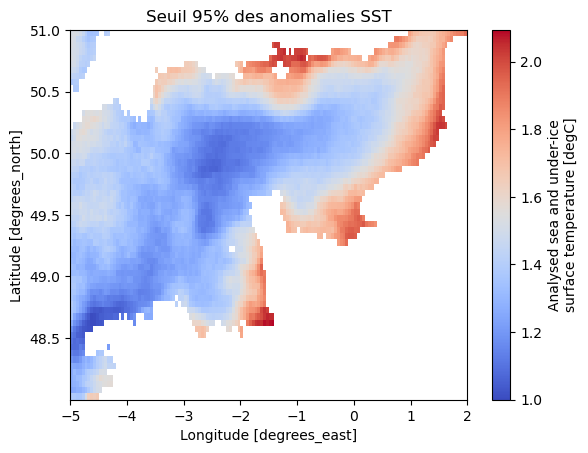

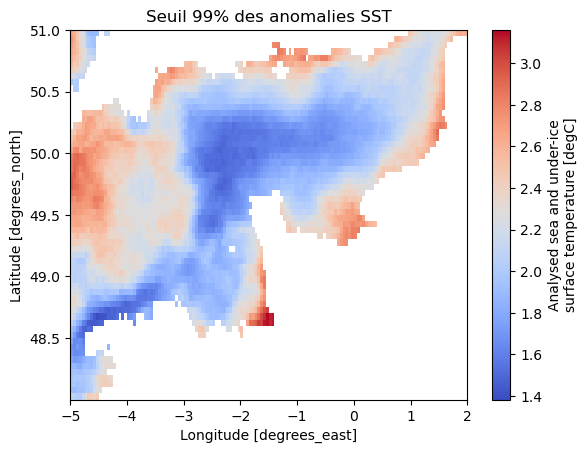

In [3]:
# Extremes analysis pixel-wise for hot events

q95 = sst.quantile(0.95, dim="time")
q99 = sst.quantile(0.99, dim="time")

q95.plot(cmap="coolwarm")
plt.title("Seuil 95% des anomalies SST")
plt.show()

q99.plot(cmap="coolwarm")
plt.title("Seuil 99% des anomalies SST")
plt.show()

Sans surprise, l'hétérogénéité spatiale est de mise. 

On observe des extrêmes locaux surtout au niveau des côtes ce qui est cohérent avec des évènements "rares" (95%) et "exceptionnels" (99%) de vagues de chaleur océaniques. Cela peut être lié à un ensemble de mécanismes connus : circulation côtière, faible profondeur, inertie thermique réduite (voir Compendium). 

On notera que des extrêmes locaux apparaissent à l'ouest de la carte pour les évènements exceptionnels (jonction entre la zone plus fermée et l'océan Atlantique). Cela pourrait correspondre à un important épisode de vagues de chaleur provenant de l'Atlantique.

Ce qu'on retiendra c'est l'interprétabilité physiquement logique constatée. Les évènements rares sont localisés et semblent être la conséquence de conditions dynamiques spécifiques à une échelle réduite. C'est un excellent indicateur de réalisme.

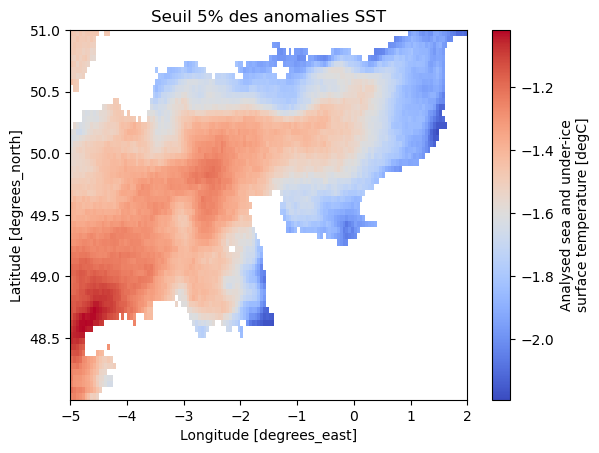

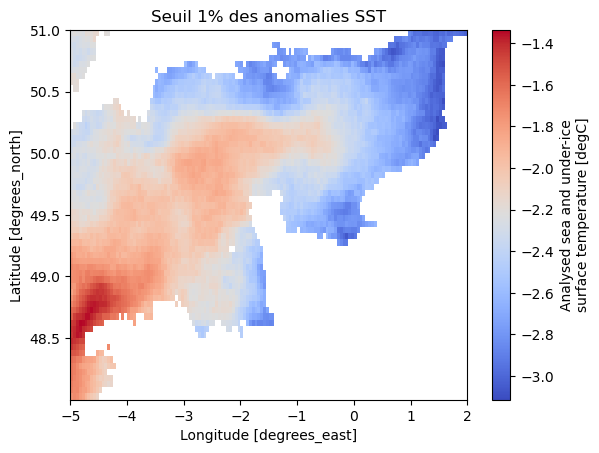

In [4]:
# Extremes analysis pixel-wise for cold events

q1 = sst.quantile(0.01, dim="time")
q5 = sst.quantile(0.05, dim="time")

q5.plot(cmap="coolwarm")
plt.title("Seuil 5% des anomalies SST")
plt.show()

q1.plot(cmap="coolwarm")
plt.title("Seuil 1% des anomalies SST")
plt.show()

C'est en observant ces deux cartes supplémentaires que l'on peut attester de la dynamique opposée entre chaud et froid.

La structuration spatiale des extrêmes est totalement inversée, les seuils froids sont franchies surtout au large côté Ouest-Atlantique. C’est totalement cohérent avec des refroidissements intenses, des intrusions d’eaux froides ou des événements hivernaux extrêmes. 

Ces phénomènes peuvent provoquer des extrêmes de fraîcheur se diffussa,t à l'échelle de la Manche à partir de l'océan Atlantique et cela fait sens avec les résultats observés.

&nbsp;

En comparant le 95ème percentile et le 99ème, puis le 5ème au 1er, on constate que plus l'évènement est rare plus il est localisé spatialement. Cela est également cohérent avec les dynamiques océaniques reconnues (voir Compendium).

&nbsp;

---

&nbsp;

### 2.3 Série temporelle des anomalies avec seuil des extrêmes

Ce qui serait désormais intéressant serait de déterminer comment se répartisse les évènements extrêmes "chauds" ou "froids" sur le plan temporelle, soit répondre au "Quand ?".



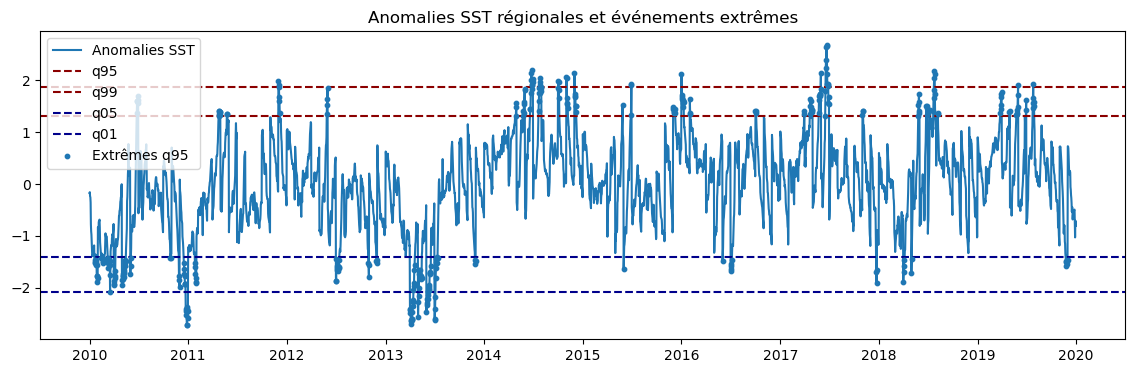

In [5]:
# We init cold and hot masks for the regional average
maskHot95 = sstReg >= q95Reg
maskCold05 = sstReg <= q5Reg

# We combine it to have a global mask of extremes
globalMask = maskHot95 | maskCold05

# We extract the extreme events
x = sstReg.time.where(globalMask, drop=True)
y = sstReg.where(globalMask, drop=True)

plt.figure(figsize=(14, 4))
plt.plot(sstReg.time, sstReg, label="Anomalies SST")

plt.axhline(q95Reg, linestyle="--", label="q95", color="darkred")
plt.axhline(q99Reg, linestyle="--", label="q99", color="darkred")

plt.axhline(q5Reg, linestyle="--", label="q05", color="darkblue")
plt.axhline(q1Reg, linestyle="--", label="q01", color="darkblue")

plt.scatter(
    x,
    y,
    s=10,
    label="Extrêmes q95",
    zorder=3
)

plt.legend()
plt.title("Anomalies SST régionales et événements extrêmes")
plt.show()



Ce n'est pas encore l'analyse de la saisonnalité des extrêmes mais l'on peut constater une certaine alternance-récurrence des extrêmes entre "chaud" et "froid". Ceux-ci sont rares mais récurrents (chaque année).

Ils sont relativement organisés temporellement, c'est-à-dire qu'on peut observer des "clusters" d'extrêmes correspondant à des évènements sur plusieurs jours consécutifs.

On remarque deux évènements de vague de froid qui se démarquent des autres l'un durant l'hiver 2010-2011, l'autre durant la première partie de 2013. Pour le chaud, on en remarque un en mi-2017. Voir Compendium si cela peut correspondre à des évènements météorologiques connus dans la région durant les mêmes périodes.

&nbsp;

La figure nous démontre un degré remarquable de persistance, non-linéarité et dépendance temporelle des extrêmes. Cela suggère une mémoire dynamique du système et justifie directement l’utilisation de modèles SciML capables de capturer les transitions de régime.

&nbsp;

---

&nbsp;

## 3. Fréquence des évènements extrêmes

> #### À quelle fréquence apparaisse les évènements extrêmes par an et par saison ?

Chercher à répondre à cette question a principalement un intérêt descriptif et de consolidation de nos hypothèses d'interprétation physique (notamment sur la dualité chaud et froid). Le but principal est de déterminer d'éventuels patterns récurrents d'apparition d'extrêmes.

In [6]:
# Detection of hot extreme events (above q95) and their start times

values = sstReg.values
time = pd.to_datetime(sstReg.time.values)

hotStarts = []
hotYears = []
hotSeasons = []

inEvent = False
startidx = None

# The idea is to loop through the values and detect when we enter and exit an extreme event
# If we enter an event (value > q95), we mark the start index
# When we exit the event (value < q95), we record the start time, year, and season
for i, x in enumerate(values):
    if (x > q95Reg) and not inEvent:
        inEvent = True
        startIdx = i

    elif (x <= q95Reg) and inEvent:
        inEvent = False
        t0 = time[startIdx]
        hotStarts.append(t0)
        hotYears.append(t0.year)

        if t0.month in [12, 1, 2]:
            hotSeasons.append("Winter")
        elif t0.month in [3, 4, 5]:
            hotSeasons.append("Spring")
        elif t0.month in [6, 7, 8]:
            hotSeasons.append("Summer")
        else:
            hotSeasons.append("Autumn")

# To account for an event that might be ongoing at the end of the series
if inEvent:
    t0 = time[startIdx]
    hotStarts.append(t0)
    hotYears.append(t0.year)
    if t0.month in [12, 1, 2]:
        hotSeasons.append("Winter")
    elif t0.month in [3, 4, 5]:
        hotSeasons.append("Spring")
    elif t0.month in [6, 7, 8]:
        hotSeasons.append("Summer")
    else:
        hotSeasons.append("Autumn")


In [7]:
# Detection of cold extreme events (below q05) and their start times
# We follow the same logic as for hot events

coldStarts = []
coldYears = []
coldSeasons = []

inEvent = False
startIdx = None

for i, x in enumerate(values):
    if (x < q5Reg) and not inEvent:
        inEvent = True
        startIdx = i

    elif (x >= q5Reg) and inEvent:
        inEvent = False
        t0 = time[startIdx]
        coldStarts.append(t0)
        coldYears.append(t0.year)

        if t0.month in [12, 1, 2]:
            coldSeasons.append("Winter")
        elif t0.month in [3, 4, 5]:
            coldSeasons.append("Spring")
        elif t0.month in [6, 7, 8]:
            coldSeasons.append("Summer")
        else:
            coldSeasons.append("Autumn")

if inEvent:
    t0 = time[startIdx]
    coldStarts.append(t0)
    coldYears.append(t0.year)
    if t0.month in [12, 1, 2]:
        coldSeasons.append("Winter")
    elif t0.month in [3, 4, 5]:
        coldSeasons.append("Spring")
    elif t0.month in [6, 7, 8]:
        coldSeasons.append("Summer")
    else:
        coldSeasons.append("Autumn")


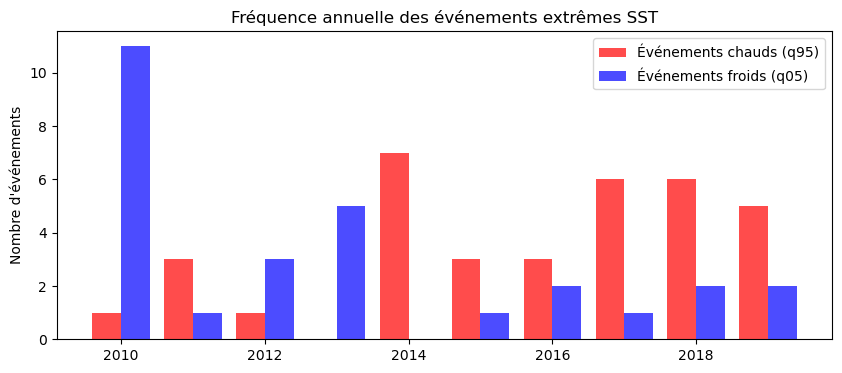

In [8]:
# Plotting the annual frequency of hot and cold extreme events

years = np.unique(time.year)

hotCountYear = [hotYears.count(y) for y in years]
coldCountYear = [coldYears.count(y) for y in years]

plt.figure(figsize=(10, 4))
plt.bar(years - 0.2, hotCountYear, width=0.4, label="Événements chauds (q95)", color="red", alpha=0.7)
plt.bar(years + 0.2, coldCountYear, width=0.4, label="Événements froids (q05)", color="blue", alpha=0.7)
plt.ylabel("Nombre d'événements")
plt.title("Fréquence annuelle des événements extrêmes SST")
plt.legend()
plt.show()


Par observation, on remarque :

- La fréquence annuelle des événements extrêmes SST est fortement variable et asymétrique entre chaud et froid.

- La variabilité interannuelle est assez marquée (de fortes fluctuations et pas de constance visible).

- Un évènement froid marquant en 2010, peut-être un épisode hivernale exceptionnel.

- Une transition vers une dominance chaude à partir de 2014 (baisse d'occurences des évènements froids et augmentation des évènements chauds). Cela peut être lié à un changement de dynamique ou un cycle saisonnier d'une échelle trop grande pour avoir été correctement désaisonnalisée (on travaille sur 10 ans, il existe peut-être des cycles longs sur 5 ans ou plus).

- Une coexistence possible chaud - froid. En effet, des transitions de régimes au sein d'une même année semblent opérées (comme l'année 2014 avec une fréquence d'apparition similaire des extrêmes chauds et froids).

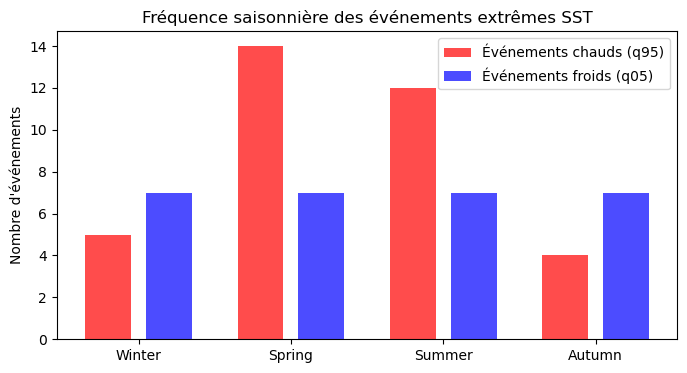

In [9]:
# Plotting the seasonal frequency of hot and cold extreme events

seasons = ["Winter", "Spring", "Summer", "Autumn"]

hotCountSeason = [hotSeasons.count(s) for s in seasons]
coldCountSeason = [coldSeasons.count(s) for s in seasons]

plt.figure(figsize=(8, 4))
plt.bar(np.array(range(len(seasons))) - 0.2, hotCountSeason, width=0.3, label="Événements chauds (q95)", color="red", alpha=0.7)
plt.bar(np.array(range(len(seasons))) + 0.2, coldCountSeason, width=0.3, label="Événements froids (q05)", color="blue", alpha=0.7)
plt.xticks(range(len(seasons)), seasons)
plt.ylabel("Nombre d'événements")
plt.title("Fréquence saisonnière des événements extrêmes SST")
plt.legend()
plt.show()

De nouveau par observation, on remarque que :

- Les évènements extrêmes froids sont très bien répartis entre les saisons sur l'année (nombre d'évènements parfaitement équilibrés d'une saison à l'autre).

- Le printemps et l'été laissent dépeindre une dominance forte des évènements extrêmes chauds. Cela peut être cohérent avec des périodes marquées par des transitions avec de fort forçage radiatif, des colonnes d’eau encore peu stratifiée, des conditions favorables à l’installation d’anomalies chaudes (voir Compendium).

&nbsp;

---

&nbsp;

## 4. Durée des évènements extrêmes

> #### Pourquoi ça nous intéresse ?

Parce que c'est une caractéristique supplémentaire à étudier pour comprendre le comportement et la dynamique des extrêmes.

Dès maintenant, on distingue explicitement les jours extrêmes, définis par un dépassement instantané de seuil, des événements extrêmes, définis comme des séquences temporelles continues de dépassement.

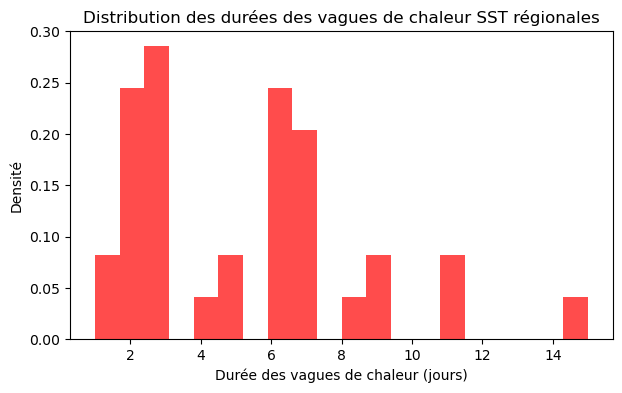

In [10]:
from scipy.ndimage import gaussian_filter1d

# We fix a threshold to analyze heatwave durations
isExtreme95 = sstReg > q95Reg

events = []
currentLength = 0

# We loop through the boolean series to find lengths of extreme events
for val in isExtreme95.values:
    if val:
        currentLength += 1
    else:
        if currentLength > 0:
            events.append(currentLength)
            currentLength = 0

# To catch an event ending at the last time step
if currentLength > 0:
    events.append(currentLength)

# We plot the distribution of event durations
plt.figure(figsize=(7, 4))
plt.xlabel("Durée des vagues de chaleur (jours)")
plt.ylabel("Densité")
plt.title("Distribution des durées des vagues de chaleur SST régionales")

# We prepare histogram data for smoothing
counts, bins, _ = plt.hist(events, bins=20, density=True, color="red", alpha=0.7)
smoothedCountsHot = gaussian_filter1d(counts, sigma=1)



On constate une multimodalité de la distribution. Une majorité d'évènements durent entre 1 et 3 jours, et entre 6 et 7 jours, au-delà de 8 jours cela devient rare. 

La distribution semble suggérer que les vagues de chaleur peinent à persister plus longtemps qu'une semaine dans la région.

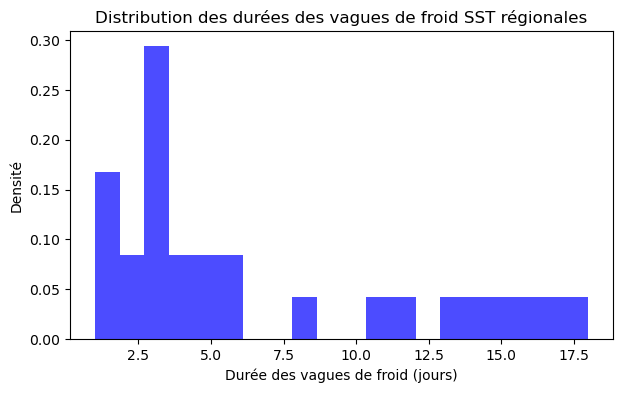

In [11]:

# Exactly the same for cold events
isExtreme05 = sstReg < q5Reg

events = []
currentLength = 0

for val in isExtreme05.values:
    if val:
        currentLength += 1
    else:
        if currentLength > 0:
            events.append(currentLength)
            currentLength = 0

if currentLength > 0:
    events.append(currentLength)

plt.figure(figsize=(7, 4))
plt.xlabel("Durée des vagues de froid (jours)")
plt.ylabel("Densité")
plt.title("Distribution des durées des vagues de froid SST régionales")

counts, bins, _ = plt.hist(events, bins=20, density=True, color="blue", alpha=0.7)
smoothedCountsCold = gaussian_filter1d(counts, sigma=1)


On constate un pic d'évènement à court terme entre 1.5 et 6 jours et une queue très étendue en durée, jusqu'à 18 jours. 

La distribution des évènements froids semblent indiquer une propension des évènements froids à persister plus longtemps. Cela suggère peut-être que des phénomènes viennent entrenir la durabilité des vagues de froid.

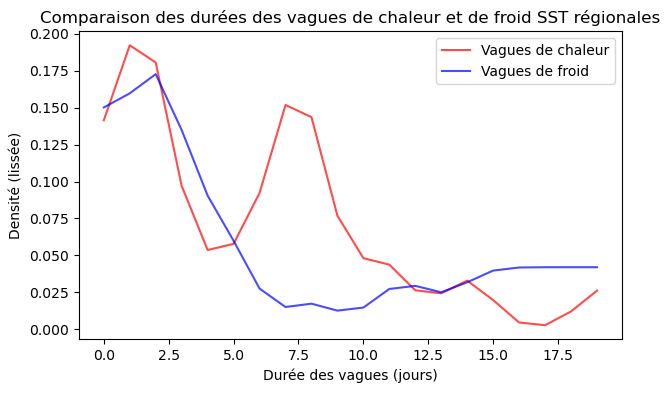

In [12]:
# We superpose both distributions

plt.figure(figsize=(7, 4))
plt.plot(smoothedCountsHot, label="Vagues de chaleur", color="red", alpha=0.7)
plt.plot(smoothedCountsCold, label="Vagues de froid", color="blue", alpha=0.7)
plt.xlabel("Durée des vagues (jours)")
plt.ylabel("Densité (lissée)")
plt.title("Comparaison des durées des vagues de chaleur et de froid SST régionales")
plt.legend()
plt.show()

La comparaison des distributions lissées de durées met en évidence la différence de comportement de persistance des évènements extrêmes chauds et froids. 

Les vagues de chaleur présentent une probabilité accrue pour des durées intermédiaires (~5–10 jours), tandis que les événements froids dominent clairement le régime des longues durées (>12 jours). Cette distinction suggère des mécanismes de persistance différents selon le signe de l’anomalie et justifie une modélisation dynamique non symétrique des extrêmes.

Un modèle simple moyen de ML échouerait ici clairement à saisir cette dissymmétrie. 

&nbsp;

---

&nbsp;

## 5. Intensité des évènements extrêmes

L'intensité ne se résume pas au pic d'une distribution. On va distinguer deux principaux type d'intensité :

- L'intensité instantannée, correspondant à l'excès par rapport au seuil : $ I(t) = X(t) - q $. L'image de la fonction mesure la violence instantannée à l'instant $t$ (ou intensité).

- L'intensité cumulée qui va combiner l'amplitude et la durée. On peut la présenter comme suit : $I_{event} = \underset{t \in event}{\sum} |X(t) - q|$.

Dans le contexte de notre analyse, c'est l'intensité cumulée qui va nous intéresser. Le caractère combinatoire de capture de l'intensité d'un évènement plutôt qu'une anomalie spontannée va nous permettre d'interpréter directement l'impact physique.

Mesurons cette intensité spécifique de la manière qui suit.

In [13]:
# Like previously, we compute hot event durations combined here with their intensities 
# For hot events

hotDurations = []
hotIntensities = []

currentLength = 0
currentIntensity = 0.0


# Same looping logic, but we also cumulate intensity
for x in values:
    if x > q95Reg:
        currentLength += 1
        currentIntensity += (x - q95Reg) # Here is the formula for cumulated intensity
    elif currentLength > 0:
        hotDurations.append(currentLength)
        hotIntensities.append(currentIntensity)
        currentLength = 0
        currentIntensity = 0.0

if currentLength > 0:
    hotDurations.append(currentLength)
    hotIntensities.append(currentIntensity)

hotDurations = np.array(hotDurations)
hotIntensities = np.array(hotIntensities)


In [14]:
# Same for cold events

coldDurations = []
coldIntensities = []

currentLength = 0
currentIntensity = 0.0

for x in values:
    if x < q5Reg:
        currentLength += 1
        currentIntensity += (q5Reg - x) # Here too
    elif currentLength > 0:
        coldDurations.append(currentLength)
        coldIntensities.append(currentIntensity)
        currentLength = 0
        currentIntensity = 0.0

if currentLength > 0:
    coldDurations.append(currentLength)
    coldIntensities.append(currentIntensity)

coldDurations = np.array(coldDurations)
coldIntensities = np.array(coldIntensities)


&nbsp;

C'est ici le bon moment d'utiliser une méthode statistique peu populaire pour mieux visualiser la dynamique de l'intensité des extrêmes des anomalies, la ECDF (Empirical Cumulative Distribution Function).

&nbsp;

> #### Pourquoi pas une simple distribution ?

On l'a vu dans les précédents *plots* de distribution, le binning (la technique de regroupement en classes pour les fréquences d'occurences) pose soucis. Étant donné qu'on a peu d'occurences à étudier la sélection de X ou Y bars pour le *barplot* est assez arbitraire. Avec l'ECDF, on esquive ce problème.

La lecture des queues peut se faire directement, contrairement aux *barplots* précédents où les observations fûrent limitées par manque de visibilité. Avec l'ECDF, on peut directement dire: "X% des évènements dépassent Y intensité".

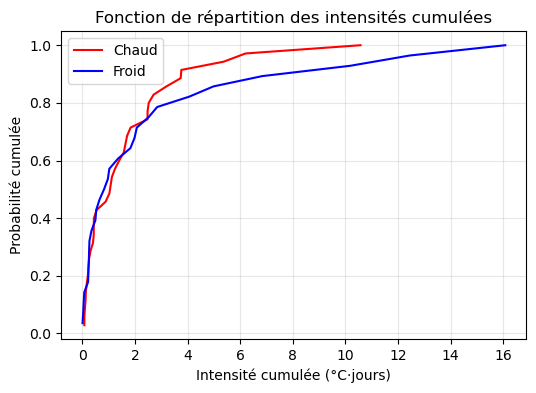

In [15]:
hotSorted = np.sort(hotIntensities)
coldSorted = np.sort(coldIntensities)

hotEcdf = np.arange(1, len(hotSorted) + 1) / len(hotSorted)
coldEcdf = np.arange(1, len(coldSorted) + 1) / len(coldSorted)

plt.figure(figsize=(6, 4))
plt.plot(hotSorted, hotEcdf, label="Chaud", color="red")
plt.plot(coldSorted, coldEcdf, label="Froid", color="blue")

plt.xlabel("Intensité cumulée (°C·jours)")
plt.ylabel("Probabilité cumulée")
plt.title("Fonction de répartition des intensités cumulées")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()




Pour les évènements extrêmes chauds (courbe rouge), on constate que la courbe monte plus rapidement aux faibles intensités. On a donc ~80-85% des évènements chauds ayant une intensité < 3 °C.jours (on remarque qu'on discute en °C.jours, donc bien à amplitude+durée). La courbe atteint relativement tôt 1 (aux alentours des 10 °C.jours). 

Concrètement, ça nous indique que la majorité des évènements chaud extrêmes sont de faibles intensités cumulées et/ou que peu d'évènements sont très intenses.

Pour les évènements extrêmes froids (courbe bleue), on observe que la courbe augmente plus lentement. Une fraction non négligeable des extrêmes dépassent 5°C.jours, voire 10°C.jours. La courbe atteint 1 seulement à 16°C.jours.

&nbsp;

En clair, les évènements froids sont moins "concentrés" sur les faibles intensités. On dira donc qu'il domine les intensités extrêmes dans notre contexte ou que :

> À intensité élevée, pour les extrêmes, les évènements froids sont plus probables que les évènements chauds.



In [16]:
print("Chaud :")
print("  Intensité moyenne :", hotIntensities.mean())
print("  Intensité max     :", hotIntensities.max())

print("Froid :")
print("  Intensité moyenne :", coldIntensities.mean())
print("  Intensité max     :", coldIntensities.max())


Chaud :
  Intensité moyenne : 1.7244734757287208
  Intensité max     : 10.576368093490615
Froid :
  Intensité moyenne : 2.6193729734846523
  Intensité max     : 16.082435309886932


&nbsp;

---

&nbsp;

## 6. Conclusion et implication pour le SciML

&nbsp;

Cette analyse nous a permis de finement caractériser la dynamique des évènements "rares" de SST à l'échelle régionale, en distanguant leur fréquence, leur durée, leur intensité cumulée et leur organisation saisonnière.

On retiendra plusieurs observation :

- Les événements extrêmes présentent une forte variabilité interannuelle semblant suggérer que des régimes climatiques à grande échelle influencent les anomalies de SST plutôt qu’un comportement aléatoire.

- La fréquence des événements est fortement modulée par la saison, avec une dominance remarquable des événements chauds au printemps–été.

- Les distributions de durée sont asymétriques et à queue longue, traduisant une persistance non négligeable des événements, en particulier pour les extrêmes froids.

- L'ensemble des métriques observées au cours de l'analyse semble mettre en évidence une dissymétrie chaud/froid, les événements froids présentant des intensités cumulées plus élevées et une queue de distribution plus lourde. Une part significative des évènements extrêmes chauds persiste jusqu'à 8 jours, pour celle des évènements froids c'est plutôt 2 jours mais la queue est plus longue, plus d'évènements arrivent donc à persister "longtemps".

&nbsp;

L'analyse nous montre que la difficulté principale ne réside pas dans la prédiction des valeurs moyennes, mais plutôt dans l'occurence des extrêmes, leur durée et leur intensité cumulée, et cela associé à des régimes non-linéaires.

Ces résultats imposent plusieurs contraintes fortes pour la modélisation :

- Le modèle doit être capable de reproduire la persistance temporelle des événements, et non uniquement des fluctuations instantanées.

- La saisonnalité doit être intégrée explicitement comme un forçage ou une variable structurante.

- Les événements chauds et froids ne peuvent pas être traités de manière strictement symétrique.

- L’évaluation du modèle ne peut pas reposer uniquement sur des métriques globales et doit inclure des indicateurs dits "événementiels" (fréquence, durée, intensité).
